<a href="https://colab.research.google.com/github/gmauricio-toledo/NLP-MCD/blob/main/03-Preprocesamiento-Intermedio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Algunas aplicaciones de pre-procesamiento de texto</h1>

En esta notebook veremos algunos ejemplos de aplicaciones de las técnicas de pre-procesamiento de texto vistas en la notebook anterior.

Usando el etiqutado POS identificaremos patrones sintácticos en el texto. Además, usaremos `wordnet` como herramienta para descubrir y describir relaciones entre palabras.

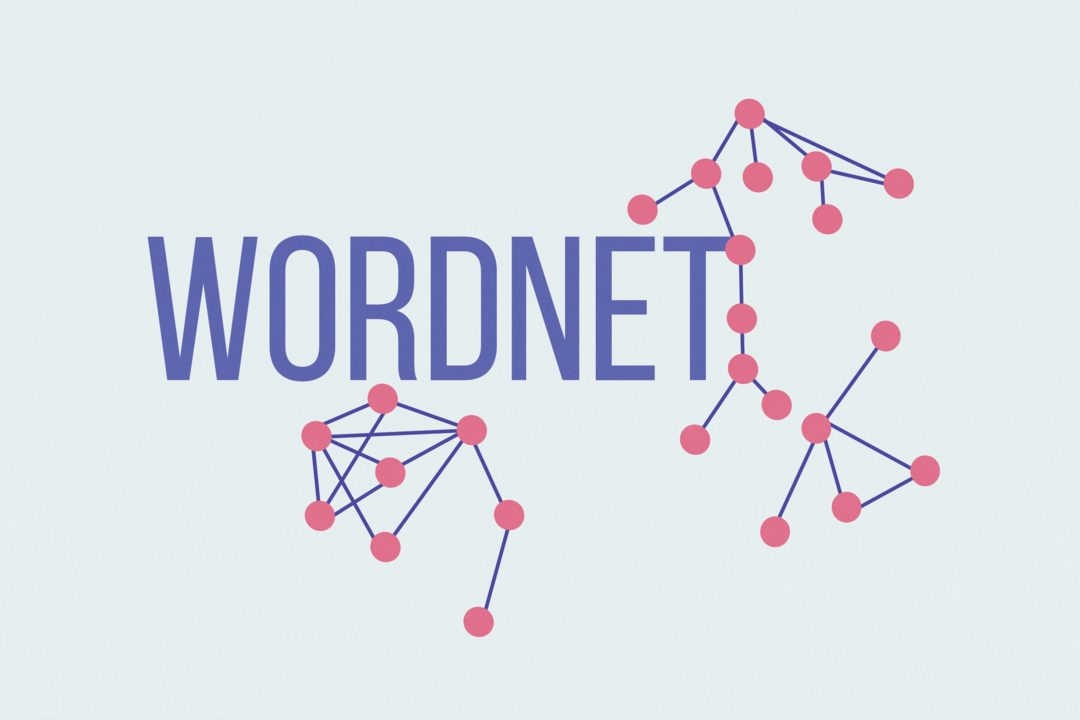

In [ ]:
 import spacy

 nlp = spacy.load("en_core_web_sm")


spaCy cuenta con funcionalidades de empatado de patrones del tipo regex, pero apoyándose en atributos como las etiquetas POS, lemas, dependencias, etc.

Más información:

* https://spacy.io/usage/rule-based-matching<br>
* https://explosion.ai/demos/matcher
* Matcher: https://spacy.io/api/matcher


## Ejemplo 1

En este ejemplo buscaremos patrones para un bot de reservaciones de un hotel. Iremos refinando este ejemplo sucesivamente.

In [ ]:
from spacy.matcher import Matcher

matcher = Matcher(nlp.vocab)

In [ ]:
# text = "I want to book a hotel room."

text = input("How can I help you:")
doc = nlp(text)

Aquí definimos el patrón que buscamos. Consiste en una secuencia de diccionarios definiendo cada patrón que buscamos. Cada diccionario trata sobre un token. En este caso, buscamos:

* El primer token es la palabra 'book'.
* El segundo token es un artículo determinado que aparece 0 o 1 vez.
* El tercer token es un sustantivo apareciendo 1 o varias veces.

In [ ]:
pattern = [
  {'TEXT': 'book'},
  {'POS': 'DET', 'OP': '?'},
  {'POS': 'NOUN', 'OP': '+'},
]

matcher.add('intencion', [pattern])

In [ ]:
matches = matcher(doc)
print("Matches:", [doc[start:end].text for match_id, start, end in matches])

El match consta de un *id* y los índices de inicio y fin.

In [ ]:
print(matches)

¿Qué estamos detectando con este patrón?

In [ ]:
pattern = [
  {'TEXT': 'book'},
  {'POS': 'DET', 'OP': '?'},
  {'POS': 'ADJ', 'OP': '*'},
  {'POS': 'NOUN', 'OP': '+'},
]

matcher.add('intencion', [pattern])

Hay muchas cosas que se pueden hacer con estos patrones: https://spacy.io/api/matcher#patterns

Discutamos algunas consideraciones:

- ¿Qué pasa si el verbo "book" está en mayusculas?
- ¿Qué pasa si se usa "reserve" en lugar de "book"?
- ¿Qué pasa si se usa "booking" o "booked" en lugar de "book"?
- ¿Cómo identificar "hotel room" como un sustantivo compuesto?
- ¿Qué pasa si se escribe "book a flight and hotel room"?
- ¿Qué pasa si se escribe "reserve 2 rooms"?

⭕ Veamos uno de ellos, el resto los analizarán de tarea.

### ¿Qué pasa si se usa "reserve" en lugar de "book"?

In [ ]:
text_1 = "I want to reserve a hotel room."
text_2 = "Id like to book a big suite."

In [ ]:
pattern = [
  {'TEXT': {'IN': ['book','reserve']}},
  {'POS': 'DET', 'OP': '?'},
  {'POS': 'ADJ', 'OP': '*'},
  {'POS': 'NOUN', 'OP': '+'},
]

matcher.add('intencion', [pattern])

In [ ]:
doc = nlp(text_2)

matches = matcher(doc)
print("Matches:", [doc[start:end].text for match_id, start, end in matches])

¿Qué pasa si usamos otros sinónimos del verbo *book*?

In [ ]:
text_3 = "I want to hold a hotel room for me"

doc = nlp(text_3)

matches = matcher(doc)
print("Matches:", [doc[start:end].text for match_id, start, end in matches])

Usemos `wordnet` para encontrar más sinónimos potenciales de este verbo. `WordNet` es una base de datos léxica del inglés (y otros idiomas), fue creada en la decada de los 80s en Princeton y ha sido mantenida y actualizada desde entonces. Mediante el uso de conjuntos llamados `synsets`, esta base de daots ayuda a encontrar relaciones conceptuales entre palabras como hiperónimos, hipónimos, sinónimos, antónimos, etc.

* Más información: https://wordnet.princeton.edu/
* NLTK tiene una interfaz para usar wordnet: https://www.nltk.org/api/nltk.corpus.reader.wordnet.html

Exploraremos `wordnet` como herramienta para desambiguar, y para construir sinónimos y antónimos.

In [ ]:
import nltk
from nltk.corpus import wordnet as wn

nltk.download('wordnet')

Podemos consultar los synsets donde se encuentra *book*.

In [ ]:
wn.synsets('book')

Podemos explorar los synsets:

In [ ]:
wn.synsets('book')[1].definition()

Exploremos todos

In [ ]:
for x in wn.synsets('book'):
    print(x.definition())
    print(x.lemma_names(),end='\n\n')

Podemos consultar sólo un POS específico

In [ ]:
wn.synsets('book',pos=wn.VERB)

In [ ]:
for x in wn.synsets('book',pos=wn.VERB):
    print(x.definition())
    print(x.lemma_names(),end='\n\n')

Veamos algunos sinónimos:

In [ ]:
S = wn.synonyms('book')
print(len(S))
S

Veamos cómo funcionan los antónimos

In [ ]:
print(wn.synsets('rise',pos=wn.VERB),end='\n\n')
for w in wn.synsets('rise',pos=wn.VERB)[0].lemmas():
    print(w)
    print(w.name())
    print(w.antonyms())

Veamos todos los sinónimos y antónimos de una palabra

In [ ]:
synonyms = []
antonyms = []

for syn in wn.synsets("good"):
	for l in syn.lemmas():
		synonyms.append(l.name())
		if l.antonyms():
			antonyms.append(l.antonyms()[0].name())

print(set(synonyms))
print(set(antonyms))

Ahora sí, recuperemos todos los sinónimos del verbo *book*.

In [ ]:
SY = wn.synsets('book',pos=wn.VERB)

sinonimos = []
for synset in SY:
    for lemma in synset.lemmas():
        sinonimos.append(lemma.name())
        print(lemma.name())
sinonimos = list(set(sinonimos))
print(sinonimos)

In [ ]:
text_4 = "I want to hold a hotel room for me"
text_5 = "I want to reserve a small suite"

pattern = [
  {'TEXT': {'IN': sinonimos}},
  {'POS': 'DET', 'OP': '?'},
  {'POS': 'ADJ', 'OP': '*'},
  {'POS': 'NOUN', 'OP': '+'},
]

matcher.add('intencion', [pattern])

doc = nlp(text_5)

matches = matcher(doc)
print("Matches:", [doc[start:end].text for match_id, start, end in matches])

¿Qué podríamos hacer después?

 * Crear más reglas para ajustar diferentes patrones.
 * Buscar palabras clave basadas en POS y entidades (por ejemplo, un país) y presentar al usuario posibles intenciones para que elija una
 * Hacer que diferentes funciones de interpretación presenten respuestas y seleccionar la más probable basándose en lo que históricamente se ha aceptado con más frecuencia.
 * Hacer preguntas aclaratorias para acotar las cosas.

⭕ Ahora probemos a identificar fechas en la reservación

In [ ]:

s = "We'll be in Osaka on Feb 13th and leave on Feb 24th."
doc = nlp(s)

pattern = [
    {'ENT_TYPE': 'DATE'}
        ]

matcher.add('fechas', [pattern])

matches = matcher(doc)
print("Matches:", [doc[start:end].text for match_id, start, end in matches])
#

In [ ]:
for x in doc.ents:
    print(x, x.label_)